# Step 3: Data Exploring
## Indonesian Hate Speech Detection - Visualization and Exploratory Data Analysis

This notebook focuses on:
- Loading processed data from Step 2
- Comprehensive visualization of class distribution
- Text analysis and word frequency exploration
- Pattern analysis between hate speech and normal text
- Statistical insights and data understanding

### Objectives:
- Visualize data distribution and characteristics
- Understand text patterns in Indonesian hate speech
- Identify key features for modeling
- Generate insights for model development

## Import Required Libraries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Text analysis
from collections import Counter
from wordcloud import WordCloud
import re
from pathlib import Path

# Statistical analysis
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("SUCCESS: Libraries imported successfully!")
print(f"INFO: Pandas version: {pd.__version__}")
print(f"INFO: Matplotlib backend: {plt.get_backend()}")

SUCCESS: Libraries imported successfully!
INFO: Pandas version: 2.2.2
INFO: Matplotlib backend: module://matplotlib_inline.backend_inline


## Load Processed Data

In [86]:
# Load processed data from Step 2
data_path = Path('../data/processed/tweets_cleaned.csv')

print(f"INFO: Loading processed data from: {data_path}")

try:
    df = pd.read_csv(data_path, encoding='utf-8')
    print(f"SUCCESS: Data loaded successfully with UTF-8 encoding!")
except UnicodeDecodeError:
    try:
        df = pd.read_csv(data_path, encoding='latin-1')
        print(f"SUCCESS: Data loaded successfully with Latin-1 encoding!")
    except Exception as e:
        print(f"ERROR: Error loading data: {str(e)}")
        raise

print(f"\nDATASET INFORMATION:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
print(f"\nFIRST 5 ROWS:")
display(df.head())

# Basic data validation
print(f"\nDATA QUALITY CHECK:")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

if 'Tweet_cleaned' in df.columns:
    empty_texts = (df['Tweet_cleaned'].str.len() == 0).sum()
    print(f"Empty cleaned texts: {empty_texts}")

INFO: Loading processed data from: ..\data\processed\tweets_cleaned.csv
SUCCESS: Data loaded successfully with UTF-8 encoding!

DATASET INFORMATION:
Shape: (13169, 14)
Columns: ['Tweet', 'HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong', 'Tweet_cleaned']
Memory usage: 5.32 MB

FIRST 5 ROWS:


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_cleaned
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,rt user: user siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,"41. kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,user user aku itu aku\n\nku tau matamu sipit t...
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,user user kaum cebong kapir udah keliatan dong...



DATA QUALITY CHECK:
Missing values: 0
Duplicate rows: 125
Empty cleaned texts: 0


## Class Distribution Analysis

In [87]:
# Analyze class distribution
if 'HS' in df.columns:
    print("CLASS DISTRIBUTION ANALYSIS")
    print("=" * 50)
    
    class_counts = df['HS'].value_counts().sort_index()
    class_proportions = df['HS'].value_counts(normalize=True).sort_index()
    
    print(f"\nClass Distribution:")
    for class_label in class_counts.index:
        count = class_counts[class_label]
        proportion = class_proportions[class_label]
        class_name = "Normal" if class_label == 0 else "Hate Speech"
        print(f"  {class_name} (Class {class_label}): {count:,} samples ({proportion:.3f} or {proportion*100:.1f}%)")
    
    # Calculate balance metrics
    balance_ratio = class_counts.max() / class_counts.min()
    print(f"\nBalance Ratio: {balance_ratio:.2f}:1")
    
    if balance_ratio <= 1.5:
        print(f"RESULT: Dataset is well balanced")
    elif balance_ratio <= 3:
        print(f"WARNING: Dataset is moderately imbalanced")
    else:
        print(f"ALERT: Dataset is highly imbalanced")
        
else:
    print("ERROR: Target column 'HS' not found in dataset")

CLASS DISTRIBUTION ANALYSIS

Class Distribution:
  Normal (Class 0): 7,608 samples (0.578 or 57.8%)
  Hate Speech (Class 1): 5,561 samples (0.422 or 42.2%)

Balance Ratio: 1.37:1
RESULT: Dataset is well balanced


## Class Distribution Visualizations

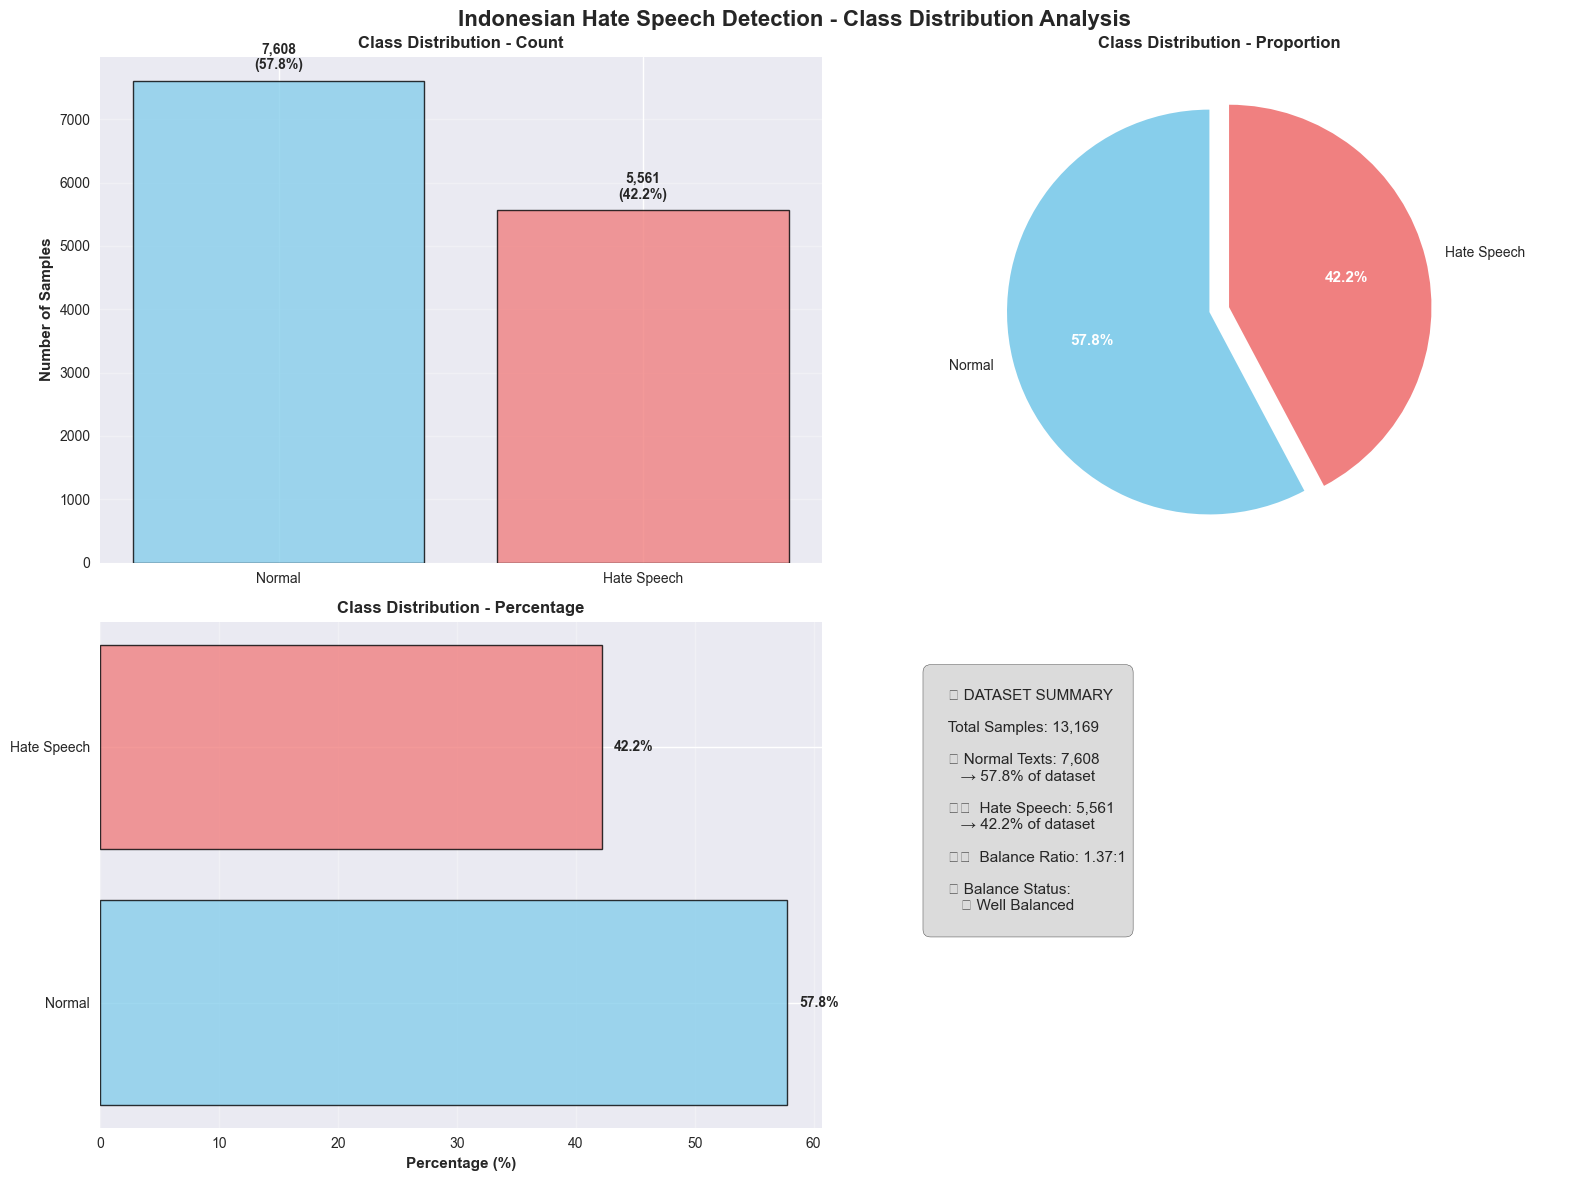

In [88]:
if 'HS' in df.columns:
    # Create comprehensive class distribution visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Indonesian Hate Speech Detection - Class Distribution Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Prepare data
    class_counts = df['HS'].value_counts().sort_index()
    class_labels = ['Normal', 'Hate Speech']
    colors = ['skyblue', 'lightcoral']
    
    # 1. Bar Chart
    bars = axes[0,0].bar(class_labels, class_counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    axes[0,0].set_title('Class Distribution - Count', fontweight='bold', fontsize=12)
    axes[0,0].set_ylabel('Number of Samples', fontweight='bold')
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, class_counts.values):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + len(df)*0.01,
                       f'{count:,}\n({count/len(df)*100:.1f}%)', 
                       ha='center', va='bottom', fontweight='bold')
    
    # 2. Pie Chart
    wedges, texts, autotexts = axes[0,1].pie(class_counts.values, labels=class_labels, colors=colors,
                                             autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
    axes[0,1].set_title('Class Distribution - Proportion', fontweight='bold', fontsize=12)
    
    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    
    # 3. Horizontal Bar Chart with Percentages
    y_pos = np.arange(len(class_labels))
    percentages = (class_counts.values / len(df)) * 100
    
    bars_h = axes[1,0].barh(y_pos, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels(class_labels)
    axes[1,0].set_xlabel('Percentage (%)', fontweight='bold')
    axes[1,0].set_title('Class Distribution - Percentage', fontweight='bold', fontsize=12)
    axes[1,0].grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars_h, percentages)):
        width = bar.get_width()
        axes[1,0].text(width + 1, bar.get_y() + bar.get_height()/2.,
                       f'{pct:.1f}%', ha='left', va='center', fontweight='bold')
    
    # 4. Summary Statistics Box
    axes[1,1].axis('off')
    
    # Create summary text
    total_samples = len(df)
    normal_count = class_counts[0] if 0 in class_counts.index else 0
    hate_count = class_counts[1] if 1 in class_counts.index else 0
    balance_ratio = max(normal_count, hate_count) / min(normal_count, hate_count) if min(normal_count, hate_count) > 0 else float('inf')
    
    summary_text = f"""
    📊 DATASET SUMMARY
    
    Total Samples: {total_samples:,}
    
    📝 Normal Texts: {normal_count:,}
       → {normal_count/total_samples*100:.1f}% of dataset
    
    ⚠️  Hate Speech: {hate_count:,}
       → {hate_count/total_samples*100:.1f}% of dataset
    
    ⚖️  Balance Ratio: {balance_ratio:.2f}:1
    
    🎯 Balance Status: 
       {'✅ Well Balanced' if balance_ratio <= 1.5 else '⚠️ Imbalanced' if balance_ratio <= 3 else '❗ Highly Imbalanced'}
    """
    
    axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                   fontsize=11, verticalalignment='top', 
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Cannot create visualizations - target column not found")

## Text Length Analysis

In [89]:
if 'Tweet_cleaned' in df.columns and 'HS' in df.columns:
    print("TEXT LENGTH ANALYSIS")
    print("=" * 50)
    
    # Calculate text statistics
    df['text_length'] = df['Tweet_cleaned'].str.len()
    df['word_count'] = df['Tweet_cleaned'].str.split().str.len()
    
    # Overall statistics
    print(f"\nOverall Text Statistics:")
    print(f"Character length - Mean: {df['text_length'].mean():.1f}, Median: {df['text_length'].median():.1f}")
    print(f"Word count - Mean: {df['word_count'].mean():.1f}, Median: {df['word_count'].median():.1f}")
    
    # Statistics by class
    print(f"\nStatistics by Class:")
    for class_label in sorted(df['HS'].unique()):
        class_name = "Normal" if class_label == 0 else "Hate Speech"
        class_data = df[df['HS'] == class_label]
        
        char_mean = class_data['text_length'].mean()
        char_median = class_data['text_length'].median()
        word_mean = class_data['word_count'].mean()
        word_median = class_data['word_count'].median()
        
        print(f"\n  {class_name}:")
        print(f"    Character length - Mean: {char_mean:.1f}, Median: {char_median:.1f}")
        print(f"    Word count - Mean: {word_mean:.1f}, Median: {word_median:.1f}")
    
    # Statistical test
    normal_lengths = df[df['HS'] == 0]['text_length']
    hate_lengths = df[df['HS'] == 1]['text_length']
    
    stat, p_value = stats.mannwhitneyu(normal_lengths, hate_lengths, alternative='two-sided')
    print(f"\nStatistical Test (Mann-Whitney U):")
    print(f"   p-value: {p_value:.6f}")
    if p_value < 0.05:
        print(f"   RESULT: Significant difference in text lengths between classes")
    else:
        print(f"   RESULT: No significant difference in text lengths between classes")
        
else:
    print("ERROR: Required columns not found for text length analysis")

TEXT LENGTH ANALYSIS

Overall Text Statistics:
Character length - Mean: 114.2, Median: 100.0
Word count - Mean: 17.3, Median: 15.0

Statistics by Class:

  Normal:
    Character length - Mean: 123.0, Median: 107.5
    Word count - Mean: 18.4, Median: 16.0

  Hate Speech:
    Character length - Mean: 102.2, Median: 94.0
    Word count - Mean: 15.7, Median: 14.0

Statistical Test (Mann-Whitney U):
   p-value: 0.000000
   RESULT: Significant difference in text lengths between classes


## Text Length Visualizations

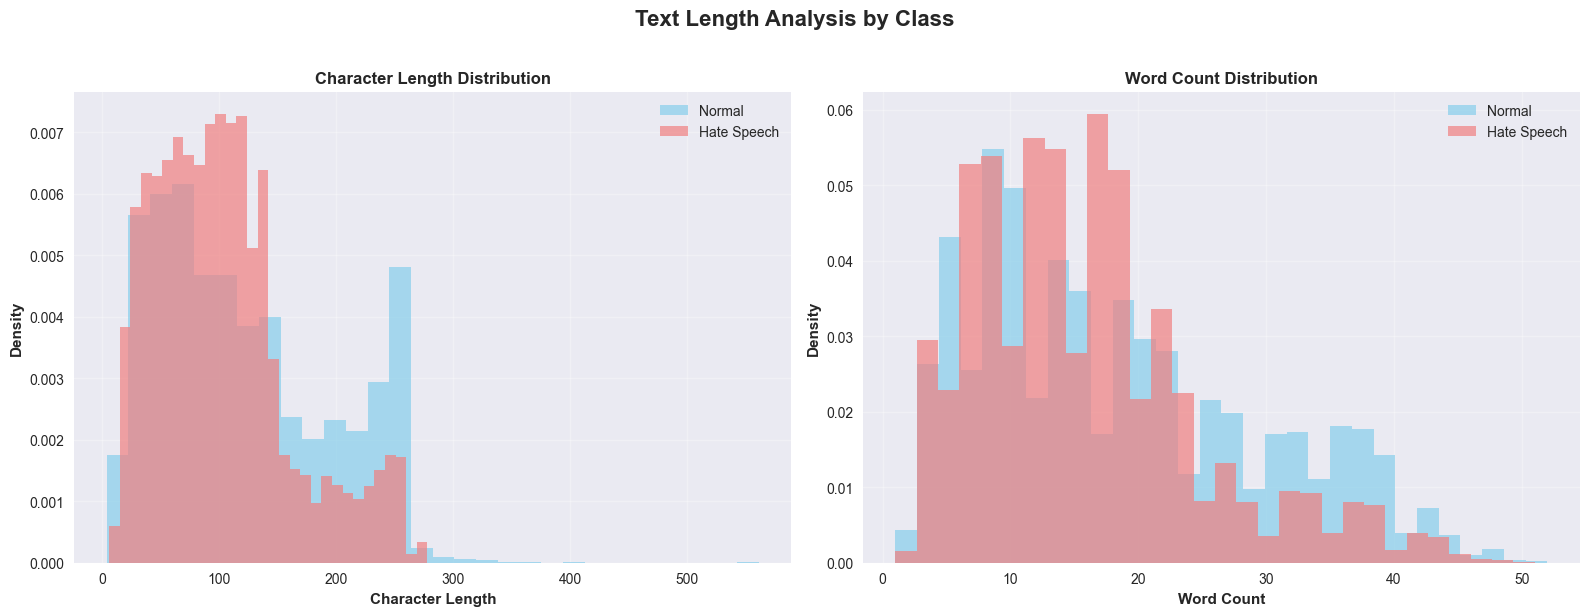


Detailed Length Statistics:

Character Length Quartiles:
Normal - Q1: 60.0, Q2: 107.5, Q3: 183.0
Hate Speech - Q1: 58.0, Q2: 94.0, Q3: 131.0

Word Count Quartiles:
Normal - Q1: 9.0, Q2: 16.0, Q3: 26.0
Hate Speech - Q1: 9.0, Q2: 14.0, Q3: 20.0


In [90]:
if 'text_length' in df.columns and 'word_count' in df.columns and 'HS' in df.columns:
    # Create text length visualizations (without box plots)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Text Length Analysis by Class', fontsize=16, fontweight='bold', y=1.02)
    
    # Prepare data
    normal_data = df[df['HS'] == 0]
    hate_data = df[df['HS'] == 1]
    
    # 1. Character Length Distribution
    axes[0].hist(normal_data['text_length'], bins=30, alpha=0.7, label='Normal', color='skyblue', density=True)
    axes[0].hist(hate_data['text_length'], bins=30, alpha=0.7, label='Hate Speech', color='lightcoral', density=True)
    axes[0].set_xlabel('Character Length', fontweight='bold')
    axes[0].set_ylabel('Density', fontweight='bold')
    axes[0].set_title('Character Length Distribution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # 2. Word Count Distribution
    axes[1].hist(normal_data['word_count'], bins=30, alpha=0.7, label='Normal', color='skyblue', density=True)
    axes[1].hist(hate_data['word_count'], bins=30, alpha=0.7, label='Hate Speech', color='lightcoral', density=True)
    axes[1].set_xlabel('Word Count', fontweight='bold')
    axes[1].set_ylabel('Density', fontweight='bold')
    axes[1].set_title('Word Count Distribution', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print quartile information
    print(f"\nDetailed Length Statistics:")
    print(f"\nCharacter Length Quartiles:")
    print(f"Normal - Q1: {normal_data['text_length'].quantile(0.25):.1f}, Q2: {normal_data['text_length'].quantile(0.5):.1f}, Q3: {normal_data['text_length'].quantile(0.75):.1f}")
    print(f"Hate Speech - Q1: {hate_data['text_length'].quantile(0.25):.1f}, Q2: {hate_data['text_length'].quantile(0.5):.1f}, Q3: {hate_data['text_length'].quantile(0.75):.1f}")
    
    print(f"\nWord Count Quartiles:")
    print(f"Normal - Q1: {normal_data['word_count'].quantile(0.25):.1f}, Q2: {normal_data['word_count'].quantile(0.5):.1f}, Q3: {normal_data['word_count'].quantile(0.75):.1f}")
    print(f"Hate Speech - Q1: {hate_data['word_count'].quantile(0.25):.1f}, Q2: {hate_data['word_count'].quantile(0.5):.1f}, Q3: {hate_data['word_count'].quantile(0.75):.1f}")
    
else:
    print("ERROR: Text length data not available for visualization")

## Word Frequency Analysis

In [91]:
if 'Tweet_cleaned' in df.columns and 'HS' in df.columns:
    print("🔤 WORD FREQUENCY ANALYSIS")
    print("=" * 50)
    
    # Separate texts by class
    normal_texts = df[df['HS'] == 0]['Tweet_cleaned'].str.cat(sep=' ')
    hate_texts = df[df['HS'] == 1]['Tweet_cleaned'].str.cat(sep=' ')
    all_texts = df['Tweet_cleaned'].str.cat(sep=' ')
    
    # Function to get word frequency
    def get_word_frequency(text, top_n=20):
        words = text.lower().split()
        # Filter out very short words and common non-meaningful words
        words = [word for word in words if len(word) > 2 and word.isalpha()]
        return Counter(words).most_common(top_n)
    
    # Get top words for each class
    print(f"\n📊 Top 15 words in NORMAL texts:")
    normal_words = get_word_frequency(normal_texts, 15)
    for i, (word, count) in enumerate(normal_words, 1):
        print(f"{i:2d}. {word:<15} ({count:,} times)")
    
    print(f"\n📊 Top 15 words in HATE SPEECH texts:")
    hate_words = get_word_frequency(hate_texts, 15)
    for i, (word, count) in enumerate(hate_words, 1):
        print(f"{i:2d}. {word:<15} ({count:,} times)")
    
    print(f"\n📊 Top 15 words OVERALL:")
    all_words = get_word_frequency(all_texts, 15)
    for i, (word, count) in enumerate(all_words, 1):
        print(f"{i:2d}. {word:<15} ({count:,} times)")
        
else:
    print("❌ Required columns not found for word frequency analysis")

🔤 WORD FREQUENCY ANALYSIS

📊 Top 15 words in NORMAL texts:
 1. user            (7,775 times)
 2. dan             (1,933 times)
 3. yang            (1,553 times)
 4. itu             (921 times)
 5. ada             (907 times)
 6. ini             (719 times)
 7. aku             (584 times)
 8. dari            (539 times)
 9. dengan          (510 times)
10. presiden        (507 times)
11. bisa            (485 times)
12. untuk           (471 times)
13. jadi            (464 times)
14. orang           (464 times)
15. tidak           (446 times)

📊 Top 15 words in HATE SPEECH texts:
 1. user            (7,610 times)
 2. dan             (782 times)
 3. itu             (569 times)
 4. jokowi          (528 times)
 5. ini             (511 times)
 6. url             (506 times)
 7. yang            (429 times)
 8. cebong          (386 times)
 9. ada             (373 times)
10. gak             (354 times)
11. aja             (349 times)
12. jadi            (334 times)
13. pak             (287 times)

## Word Frequency Visualizations

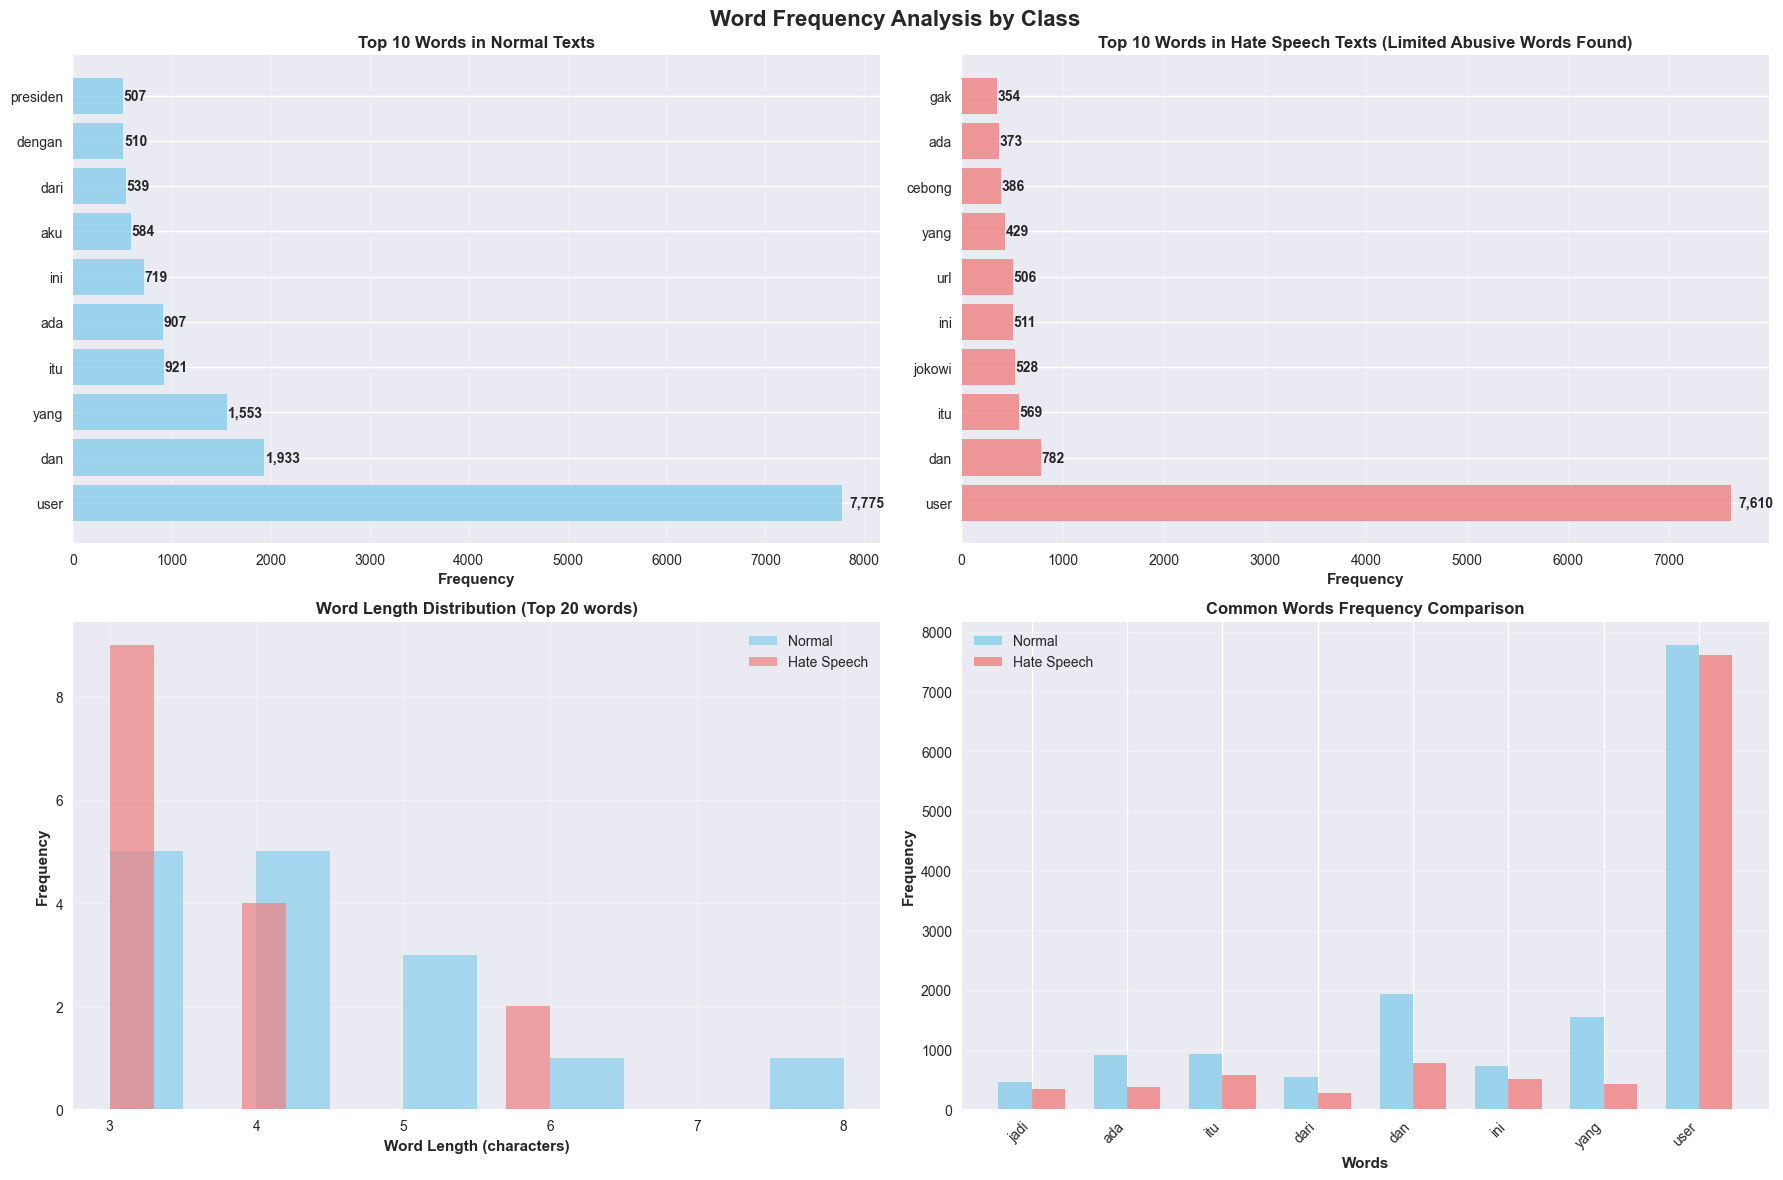

In [92]:
if 'normal_words' in locals() and 'hate_words' in locals():
    # Create word frequency visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Word Frequency Analysis by Class', fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Normal text top words
    normal_words_df = pd.DataFrame(normal_words[:10], columns=['word', 'frequency'])
    bars1 = axes[0,0].barh(range(len(normal_words_df)), normal_words_df['frequency'], 
                           color='skyblue', alpha=0.8)
    axes[0,0].set_yticks(range(len(normal_words_df)))
    axes[0,0].set_yticklabels(normal_words_df['word'])
    axes[0,0].set_xlabel('Frequency', fontweight='bold')
    axes[0,0].set_title('Top 10 Words in Normal Texts', fontweight='bold')
    axes[0,0].grid(axis='x', alpha=0.3)
    
    # Add frequency labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        axes[0,0].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                       f'{int(width):,}', ha='left', va='center', fontweight='bold')
    
    # 2. Top abusive words in hate speech texts
    try:
        # Load abusive words to filter hate speech words
        abusive_words_path = Path('../IndonesianAbusiveWords/abusive.csv')
        if abusive_words_path.exists():
            abusive_df = pd.read_csv(abusive_words_path, encoding='utf-8')
            abusive_words_set = set(abusive_df['ABUSIVE'].str.lower().str.strip())
            
            # Filter hate speech words to show only abusive words
            hate_abusive_words = [(word, freq) for word, freq in hate_words if word in abusive_words_set]
            
            if hate_abusive_words and len(hate_abusive_words) >= 5:
                # Use top abusive words if available
                hate_words_to_show = hate_abusive_words[:10]
                title = 'Top 10 Abusive Words in Hate Speech Texts'
            else:
                # Fallback to general words if not enough abusive words found
                hate_words_to_show = hate_words[:10]
                title = 'Top 10 Words in Hate Speech Texts (Limited Abusive Words Found)'
        else:
            hate_words_to_show = hate_words[:10]
            title = 'Top 10 Words in Hate Speech Texts'
    except:
        hate_words_to_show = hate_words[:10]
        title = 'Top 10 Words in Hate Speech Texts'
    
    hate_words_df = pd.DataFrame(hate_words_to_show, columns=['word', 'frequency'])
    bars2 = axes[0,1].barh(range(len(hate_words_df)), hate_words_df['frequency'], 
                           color='lightcoral', alpha=0.8)
    axes[0,1].set_yticks(range(len(hate_words_df)))
    axes[0,1].set_yticklabels(hate_words_df['word'])
    axes[0,1].set_xlabel('Frequency', fontweight='bold')
    axes[0,1].set_title(title, fontweight='bold')
    axes[0,1].grid(axis='x', alpha=0.3)
    
    # Add frequency labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        axes[0,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                       f'{int(width):,}', ha='left', va='center', fontweight='bold')
    
    # 3. Word length distribution
    normal_word_lengths = [len(word) for word, _ in normal_words[:20]]
    hate_word_lengths = [len(word) for word, _ in hate_words[:20]]
    
    axes[1,0].hist(normal_word_lengths, bins=10, alpha=0.7, label='Normal', color='skyblue')
    axes[1,0].hist(hate_word_lengths, bins=10, alpha=0.7, label='Hate Speech', color='lightcoral')
    axes[1,0].set_xlabel('Word Length (characters)', fontweight='bold')
    axes[1,0].set_ylabel('Frequency', fontweight='bold')
    axes[1,0].set_title('Word Length Distribution (Top 20 words)', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(alpha=0.3)
    
    # 4. Comparative word frequency
    # Find common words between classes
    normal_word_dict = {word: freq for word, freq in normal_words}
    hate_word_dict = {word: freq for word, freq in hate_words}
    
    common_words = set(normal_word_dict.keys()) & set(hate_word_dict.keys())
    common_words = list(common_words)[:8]  # Top 8 common words
    
    if common_words:
        normal_freqs = [normal_word_dict[word] for word in common_words]
        hate_freqs = [hate_word_dict[word] for word in common_words]
        
        x = np.arange(len(common_words))
        width = 0.35
        
        bars1 = axes[1,1].bar(x - width/2, normal_freqs, width, label='Normal', 
                              color='skyblue', alpha=0.8)
        bars2 = axes[1,1].bar(x + width/2, hate_freqs, width, label='Hate Speech', 
                              color='lightcoral', alpha=0.8)
        
        axes[1,1].set_xlabel('Words', fontweight='bold')
        axes[1,1].set_ylabel('Frequency', fontweight='bold')
        axes[1,1].set_title('Common Words Frequency Comparison', fontweight='bold')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(common_words, rotation=45, ha='right')
        axes[1,1].legend()
        axes[1,1].grid(axis='y', alpha=0.3)
        
    else:
        axes[1,1].text(0.5, 0.5, 'No common words found\nin top frequencies', 
                       ha='center', va='center', transform=axes[1,1].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        axes[1,1].set_title('Common Words Frequency Comparison', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Word frequency data not available for visualization")

## Word Clouds

GENERATING WORD CLOUDS


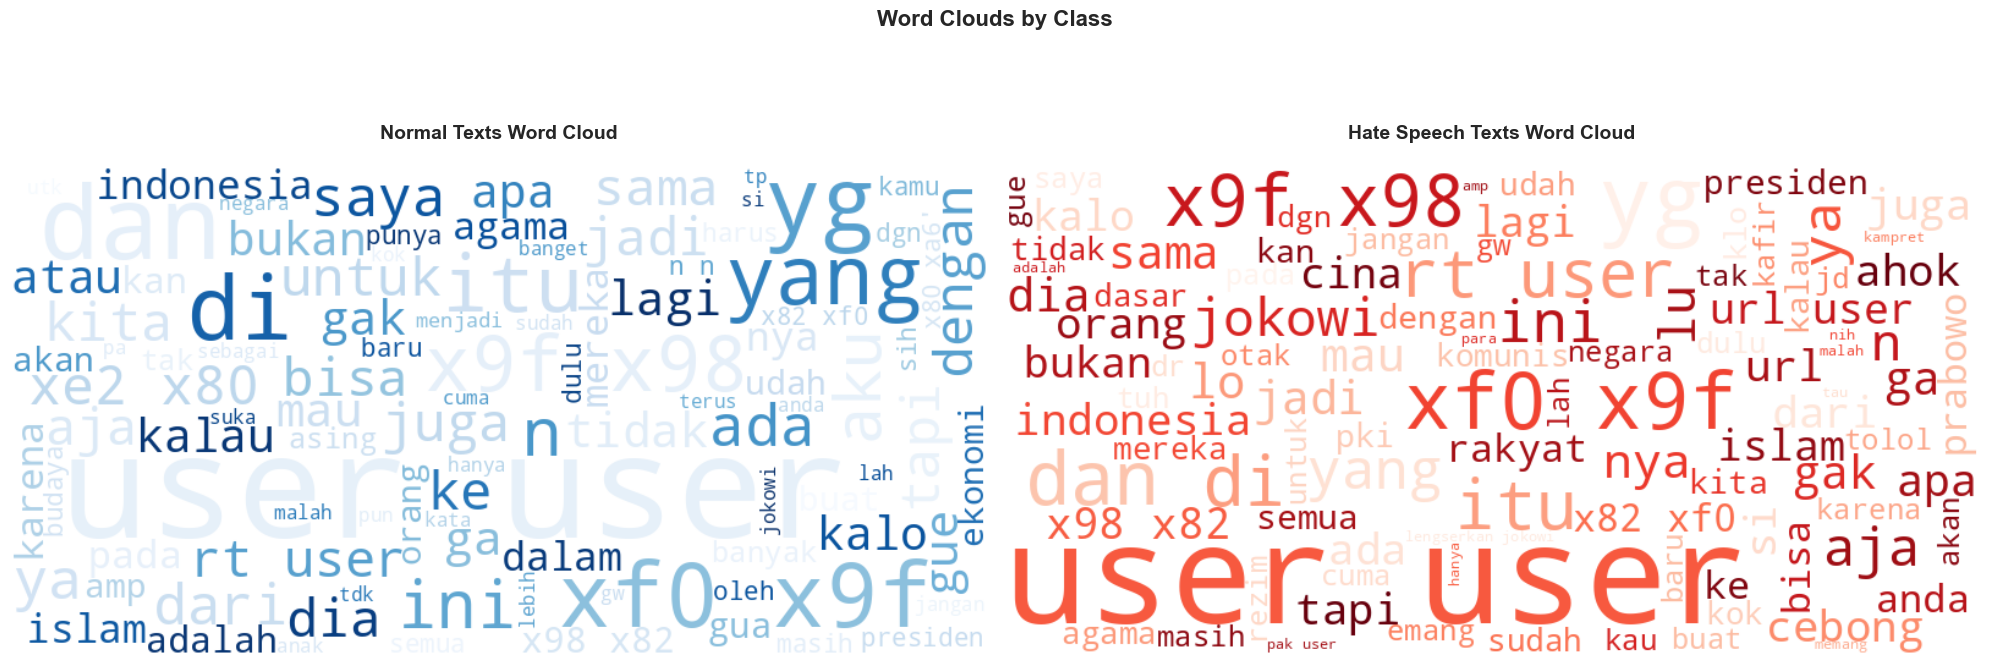

SUCCESS: Word clouds generated successfully!


In [93]:
if 'Tweet_cleaned' in df.columns and 'HS' in df.columns:
    try:
        print("GENERATING WORD CLOUDS")
        print("=" * 50)
        
        # Create word clouds
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle('Word Clouds by Class', fontsize=16, fontweight='bold')
        
        # Normal text word cloud
        normal_text = ' '.join(df[df['HS'] == 0]['Tweet_cleaned'].astype(str))
        
        wordcloud_normal = WordCloud(width=800, height=400, 
                                   background_color='white',
                                   colormap='Blues',
                                   max_words=100,
                                   relative_scaling=0.5,
                                   random_state=42).generate(normal_text)
        
        axes[0].imshow(wordcloud_normal, interpolation='bilinear')
        axes[0].set_title('Normal Texts Word Cloud', fontweight='bold', fontsize=14, pad=20)
        axes[0].axis('off')
        
        # Hate speech word cloud
        hate_text = ' '.join(df[df['HS'] == 1]['Tweet_cleaned'].astype(str))
        
        wordcloud_hate = WordCloud(width=800, height=400, 
                                 background_color='white',
                                 colormap='Reds',
                                 max_words=100,
                                 relative_scaling=0.5,
                                 random_state=42).generate(hate_text)
        
        axes[1].imshow(wordcloud_hate, interpolation='bilinear')
        axes[1].set_title('Hate Speech Texts Word Cloud', fontweight='bold', fontsize=14, pad=20)
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"SUCCESS: Word clouds generated successfully!")
        
    except ImportError:
        print(f"WARNING: WordCloud library not available. Install with: pip install wordcloud")
    except Exception as e:
        print(f"ERROR: Error generating word clouds: {str(e)}")
        
else:
    print("ERROR: Required columns not found for word cloud generation")

## TF-IDF Analysis

In [94]:
if 'Tweet_cleaned' in df.columns and 'HS' in df.columns:
    print("TF-IDF ANALYSIS")
    print("=" * 50)
    
    # Separate texts by class
    normal_texts = df[df['HS'] == 0]['Tweet_cleaned'].tolist()
    hate_texts = df[df['HS'] == 1]['Tweet_cleaned'].tolist()
    
    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.95, ngram_range=(1, 2))
    
    # Fit on all texts
    all_texts = df['Tweet_cleaned'].tolist()
    tfidf_matrix = tfidf.fit_transform(all_texts)
    feature_names = tfidf.get_feature_names_out()
    
    print(f"\nTF-IDF Matrix Shape: {tfidf_matrix.shape}")
    print(f"Number of features: {len(feature_names)}")
    
    # Get average TF-IDF scores for each class
    normal_indices = df[df['HS'] == 0].index
    hate_indices = df[df['HS'] == 1].index
    
    # Calculate mean TF-IDF scores for each class
    normal_tfidf_mean = np.array(tfidf_matrix[normal_indices].mean(axis=0)).flatten()
    hate_tfidf_mean = np.array(tfidf_matrix[hate_indices].mean(axis=0)).flatten()
    
    # Get top features for each class
    normal_top_indices = normal_tfidf_mean.argsort()[-15:][::-1]
    hate_top_indices = hate_tfidf_mean.argsort()[-15:][::-1]
    
    print(f"\nTop 15 TF-IDF features for NORMAL texts:")
    for i, idx in enumerate(normal_top_indices, 1):
        feature = feature_names[idx]
        score = normal_tfidf_mean[idx]
        print(f"{i:2d}. {feature:<20} (TF-IDF: {score:.4f})")
    
    print(f"\nTop 15 TF-IDF features for HATE SPEECH texts:")
    for i, idx in enumerate(hate_top_indices, 1):
        feature = feature_names[idx]
        score = hate_tfidf_mean[idx]
        print(f"{i:2d}. {feature:<20} (TF-IDF: {score:.4f})")
    
    # Load abusive words for filtering
    try:
        abusive_words_path = Path('../IndonesianAbusiveWords/abusive.csv')
        if abusive_words_path.exists():
            abusive_df = pd.read_csv(abusive_words_path, encoding='utf-8')
            abusive_words_set = set(abusive_df['ABUSIVE'].str.lower().str.strip())
            
            # Filter TF-IDF features to show only abusive words in hate speech
            abusive_tfidf_scores = []
            for idx, feature in enumerate(feature_names):
                # Check if the feature (or any word in the feature if it's an n-gram) is abusive
                feature_words = feature.split()
                if any(word in abusive_words_set for word in feature_words):
                    abusive_tfidf_scores.append((feature, hate_tfidf_mean[idx], idx))
            
            # Sort by TF-IDF score and get top 10
            abusive_tfidf_scores.sort(key=lambda x: x[1], reverse=True)
            top_abusive_in_hate = abusive_tfidf_scores[:10]
            
            if top_abusive_in_hate:
                print(f"\nTop 10 ABUSIVE WORDS in HATE SPEECH texts (by TF-IDF):")
                for i, (feature, score, idx) in enumerate(top_abusive_in_hate, 1):
                    print(f"{i:2d}. {feature:<20} (TF-IDF: {score:.4f})")
            else:
                print(f"\nNo abusive words found in TF-IDF features for hate speech texts")
        else:
            print(f"\nWARNING: Abusive words dataset not found - cannot filter for abusive words")
    except Exception as e:
        print(f"\nERROR: Error loading abusive words for TF-IDF filtering: {str(e)}")
    
    # Find discriminative features (features that appear more in one class than the other)
    tfidf_diff = hate_tfidf_mean - normal_tfidf_mean
    
    # Features more common in hate speech
    hate_discriminative_indices = tfidf_diff.argsort()[-10:][::-1]
    print(f"\nTop 10 features MORE common in HATE SPEECH:")
    for i, idx in enumerate(hate_discriminative_indices, 1):
        feature = feature_names[idx]
        diff = tfidf_diff[idx]
        print(f"{i:2d}. {feature:<20} (Difference: {diff:.4f})")
    
    # Features more common in normal text
    normal_discriminative_indices = tfidf_diff.argsort()[:10]
    print(f"\nTop 10 features MORE common in NORMAL texts:")
    for i, idx in enumerate(normal_discriminative_indices, 1):
        feature = feature_names[idx]
        diff = abs(tfidf_diff[idx])
        print(f"{i:2d}. {feature:<20} (Difference: {diff:.4f})")
        
else:
    print("ERROR: Required columns not found for TF-IDF analysis")

TF-IDF ANALYSIS

TF-IDF Matrix Shape: (13169, 1000)
Number of features: 1000

Top 15 TF-IDF features for NORMAL texts:
 1. user                 (TF-IDF: 0.0900)
 2. user user            (TF-IDF: 0.0515)
 3. dan                  (TF-IDF: 0.0353)
 4. di                   (TF-IDF: 0.0335)
 5. yang                 (TF-IDF: 0.0315)
 6. yg                   (TF-IDF: 0.0281)
 7. itu                  (TF-IDF: 0.0207)
 8. ada                  (TF-IDF: 0.0198)
 9. ini                  (TF-IDF: 0.0198)
10. xf0                  (TF-IDF: 0.0193)
11. x9f                  (TF-IDF: 0.0192)
12. xf0 x9f              (TF-IDF: 0.0192)
13. aku                  (TF-IDF: 0.0181)
14. presiden             (TF-IDF: 0.0173)
15. x98                  (TF-IDF: 0.0157)

Top 15 TF-IDF features for HATE SPEECH texts:
 1. user                 (TF-IDF: 0.1217)
 2. user user            (TF-IDF: 0.0836)
 3. yg                   (TF-IDF: 0.0310)
 4. jokowi               (TF-IDF: 0.0263)
 5. di                   (TF-IDF: 0.

## TF-IDF Visualizations

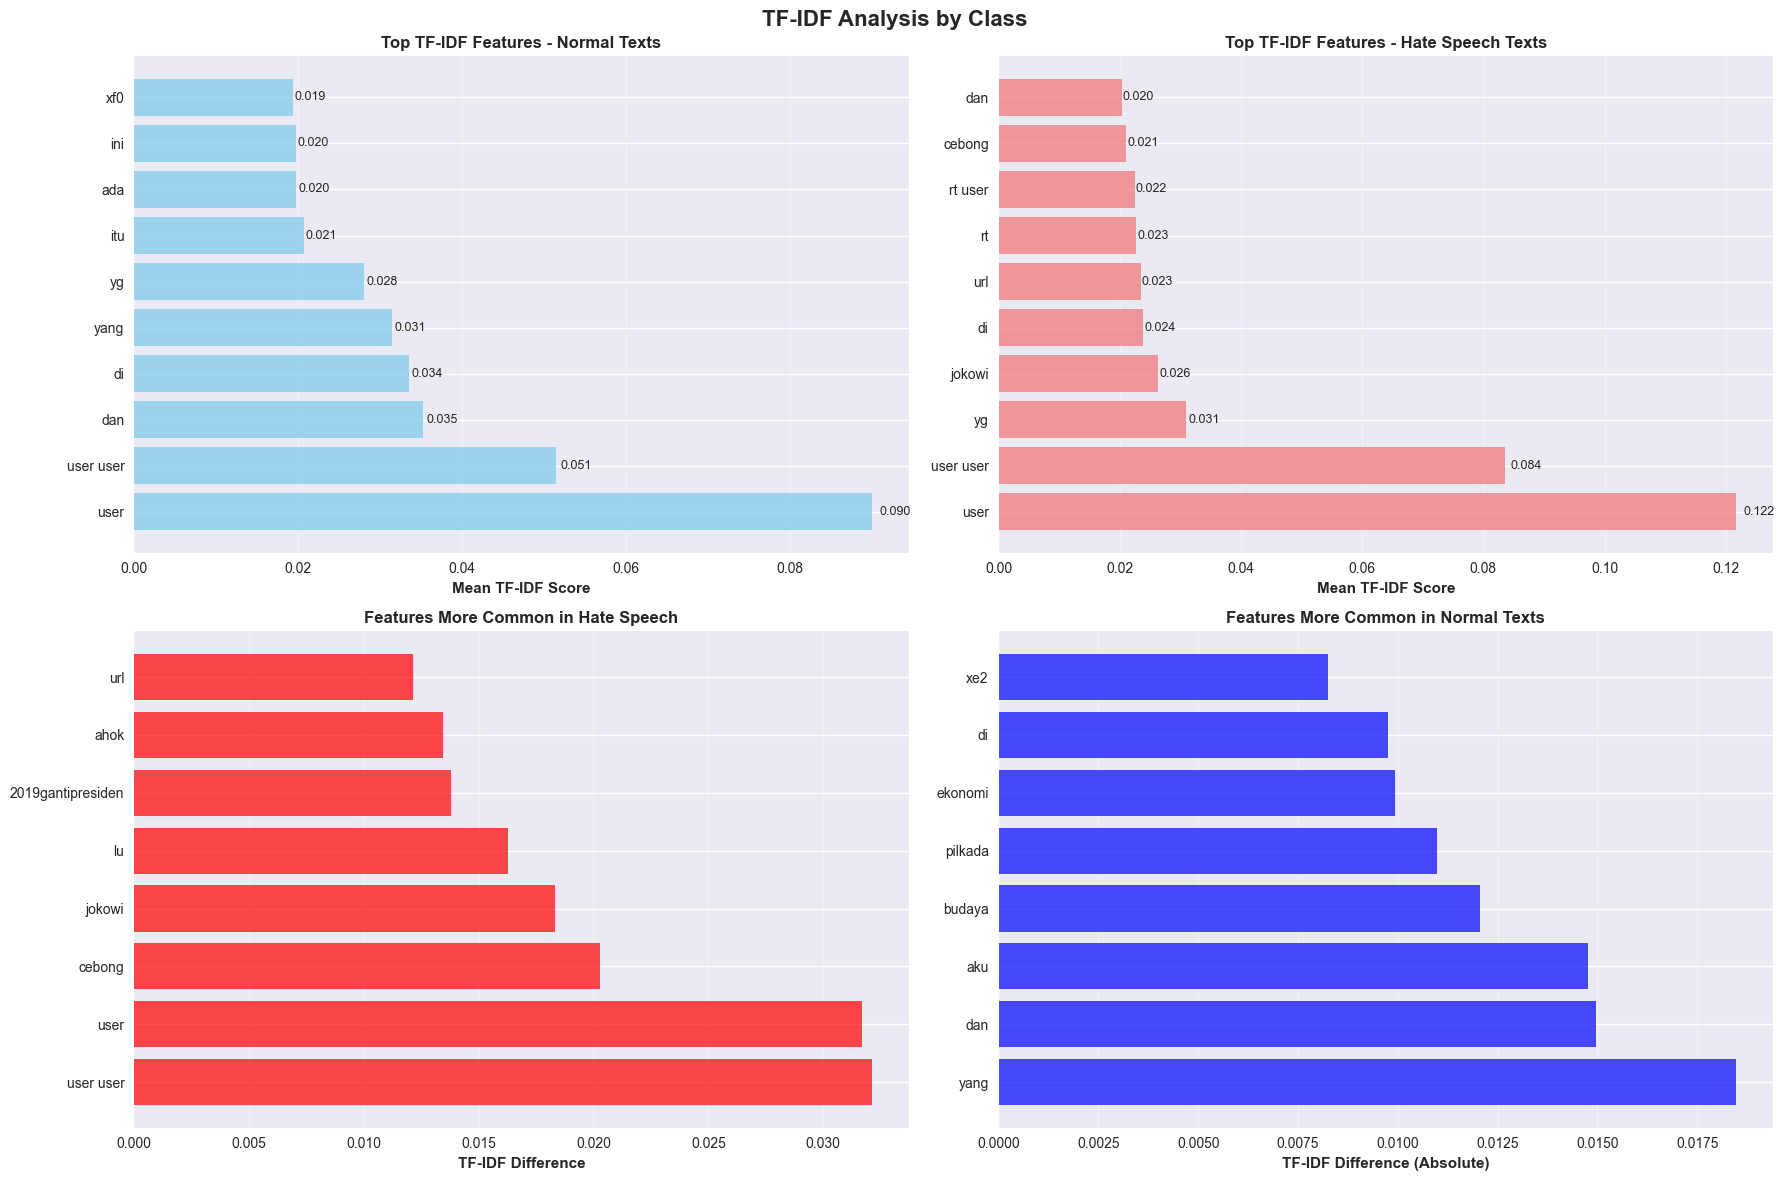

In [95]:
if 'normal_tfidf_mean' in locals() and 'hate_tfidf_mean' in locals():
    # Create TF-IDF visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('TF-IDF Analysis by Class', fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Top TF-IDF features for Normal texts
    normal_top_features = [feature_names[idx] for idx in normal_top_indices[:10]]
    normal_top_scores = [normal_tfidf_mean[idx] for idx in normal_top_indices[:10]]
    
    bars1 = axes[0,0].barh(range(len(normal_top_features)), normal_top_scores, 
                           color='skyblue', alpha=0.8)
    axes[0,0].set_yticks(range(len(normal_top_features)))
    axes[0,0].set_yticklabels(normal_top_features)
    axes[0,0].set_xlabel('Mean TF-IDF Score', fontweight='bold')
    axes[0,0].set_title('Top TF-IDF Features - Normal Texts', fontweight='bold')
    axes[0,0].grid(axis='x', alpha=0.3)
    
    # Add score labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        axes[0,0].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                       f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    # 2. Top TF-IDF features for Hate Speech texts
    hate_top_features = [feature_names[idx] for idx in hate_top_indices[:10]]
    hate_top_scores = [hate_tfidf_mean[idx] for idx in hate_top_indices[:10]]
    
    bars2 = axes[0,1].barh(range(len(hate_top_features)), hate_top_scores, 
                           color='lightcoral', alpha=0.8)
    axes[0,1].set_yticks(range(len(hate_top_features)))
    axes[0,1].set_yticklabels(hate_top_features)
    axes[0,1].set_xlabel('Mean TF-IDF Score', fontweight='bold')
    axes[0,1].set_title('Top TF-IDF Features - Hate Speech Texts', fontweight='bold')
    axes[0,1].grid(axis='x', alpha=0.3)
    
    # Add score labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        axes[0,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                       f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    # 3. Discriminative features (more in hate speech)
    hate_disc_features = [feature_names[idx] for idx in hate_discriminative_indices[:8]]
    hate_disc_scores = [tfidf_diff[idx] for idx in hate_discriminative_indices[:8]]
    
    bars3 = axes[1,0].barh(range(len(hate_disc_features)), hate_disc_scores, 
                           color='red', alpha=0.7)
    axes[1,0].set_yticks(range(len(hate_disc_features)))
    axes[1,0].set_yticklabels(hate_disc_features)
    axes[1,0].set_xlabel('TF-IDF Difference', fontweight='bold')
    axes[1,0].set_title('Features More Common in Hate Speech', fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)
    
    # 4. Discriminative features (more in normal text)
    normal_disc_features = [feature_names[idx] for idx in normal_discriminative_indices[:8]]
    normal_disc_scores = [abs(tfidf_diff[idx]) for idx in normal_discriminative_indices[:8]]
    
    bars4 = axes[1,1].barh(range(len(normal_disc_features)), normal_disc_scores, 
                           color='blue', alpha=0.7)
    axes[1,1].set_yticks(range(len(normal_disc_features)))
    axes[1,1].set_yticklabels(normal_disc_features)
    axes[1,1].set_xlabel('TF-IDF Difference (Absolute)', fontweight='bold')
    axes[1,1].set_title('Features More Common in Normal Texts', fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ TF-IDF data not available for visualization")

## Hate Speech Classification Analysis


In [96]:
print("HATE SPEECH WORD ANALYSIS")
print("=" * 50)

# Load Indonesian abusive words dataset
abusive_words_path = Path('../IndonesianAbusiveWords/abusive.csv')

if abusive_words_path.exists():
    print(f"INFO: Loading abusive words from: {abusive_words_path}")
    
    try:
        abusive_df = pd.read_csv(abusive_words_path, encoding='utf-8')
        abusive_words = set(abusive_df['ABUSIVE'].str.lower().str.strip())
        print(f"SUCCESS: Loaded {len(abusive_words)} abusive words")
        
        # Display some examples
        print(f"\nSample abusive words:")
        sample_words = list(abusive_words)[:15]
        for i, word in enumerate(sample_words, 1):
            print(f"  {i:2d}. {word}")
        
        if len(abusive_words) > 15:
            print(f"  ... and {len(abusive_words) - 15} more words")
            
    except Exception as e:
        print(f"ERROR: Error loading abusive words: {str(e)}")
        abusive_words = set()
        
else:
    print(f"ERROR: Abusive words file not found at: {abusive_words_path}")
    abusive_words = set()

# Analyze hate speech classification based on abusive words
if len(abusive_words) > 0 and 'Tweet_cleaned' in df.columns and 'HS' in df.columns:
    print(f"\nHATE SPEECH CLASSIFICATION ANALYSIS:")
    print(f"=" * 50)
    print(f"\nIMPORTANT NOTE:")
    print(f"The ground truth labels (HS) were created by human annotators based on context,")
    print(f"intent, and overall meaning - not just presence of abusive words.")
    print(f"This analysis compares rule-based classification (abusive words) vs human judgment.")
    print(f"\nWhy 'normal' texts might contain abusive words:")
    print(f"- Quoted speech or reporting")
    print(f"- Educational/informational content")
    print(f"- Discussions about the words themselves")
    print(f"- Sarcasm or different context")
    print(f"\nWhy hate speech might lack explicit abusive words:")
    print(f"- Coded language or euphemisms")
    print(f"- Subtle discrimination")
    print(f"- Context-dependent meanings")
    print(f"- Implicit threats")
    print(f"\n" + "="*50)
    
    # Function to count abusive words in text
    def count_abusive_words(text):
        if pd.isna(text):
            return 0
        text_words = set(str(text).lower().split())
        return len(text_words.intersection(abusive_words))
    
    # Function to get abusive words in text
    def get_abusive_words_in_text(text):
        if pd.isna(text):
            return []
        text_words = set(str(text).lower().split())
        return list(text_words.intersection(abusive_words))
    
    # Apply analysis to dataset
    df['abusive_word_count'] = df['Tweet_cleaned'].apply(count_abusive_words)
    df['abusive_words_found'] = df['Tweet_cleaned'].apply(get_abusive_words_in_text)
    
    # Overall statistics
    total_texts_with_abusive = (df['abusive_word_count'] > 0).sum()
    avg_abusive_per_text = df['abusive_word_count'].mean()
    
    print(f"Overall Abusive Word Statistics:")
    print(f"   Total texts containing abusive words: {total_texts_with_abusive:,} ({total_texts_with_abusive/len(df)*100:.1f}%)")
    print(f"   Average abusive words per text: {avg_abusive_per_text:.2f}")
    
    # Analysis by class - comparing human labels vs abusive word presence
    print(f"\nCOMPARISON: Human Labels vs Abusive Word Presence:")
    
    # Calculate confusion matrix style analysis
    normal_with_abusive = (df[(df['HS'] == 0) & (df['abusive_word_count'] > 0)]).shape[0]
    normal_without_abusive = (df[(df['HS'] == 0) & (df['abusive_word_count'] == 0)]).shape[0]
    hate_with_abusive = (df[(df['HS'] == 1) & (df['abusive_word_count'] > 0)]).shape[0]
    hate_without_abusive = (df[(df['HS'] == 1) & (df['abusive_word_count'] == 0)]).shape[0]
    
    total_normal = normal_with_abusive + normal_without_abusive
    total_hate = hate_with_abusive + hate_without_abusive
    
    print(f"\nDetailed Breakdown:")
    print(f"  Human-labeled NORMAL texts:")
    print(f"    With abusive words: {normal_with_abusive:,} ({normal_with_abusive/total_normal*100:.1f}%)")
    print(f"    Without abusive words: {normal_without_abusive:,} ({normal_without_abusive/total_normal*100:.1f}%)")
    print(f"    Total normal: {total_normal:,}")
    
    print(f"\n  Human-labeled HATE SPEECH texts:")
    print(f"    With abusive words: {hate_with_abusive:,} ({hate_with_abusive/total_hate*100:.1f}%)")
    print(f"    Without abusive words: {hate_without_abusive:,} ({hate_without_abusive/total_hate*100:.1f}%)")
    print(f"    Total hate speech: {total_hate:,}")
    
    # Calculate agreement between human labels and abusive word rule
    print(f"\nAGREEMENT ANALYSIS:")
    print(f"  Normal texts WITHOUT abusive words: {normal_without_abusive:,} (AGREEMENT)")
    print(f"  Hate texts WITH abusive words: {hate_with_abusive:,} (AGREEMENT)")
    print(f"  Normal texts WITH abusive words: {normal_with_abusive:,} (DISAGREEMENT)")
    print(f"  Hate texts WITHOUT abusive words: {hate_without_abusive:,} (DISAGREEMENT)")
    
    agreement_rate = (normal_without_abusive + hate_with_abusive) / len(df) * 100
    print(f"  Overall agreement rate: {agreement_rate:.1f}%")
    
    # Show examples of disagreements (if any exist)
    if normal_with_abusive > 0:
        print(f"\nEXAMPLES: Normal texts containing abusive words (first 3):")
        normal_with_abusive_examples = df[(df['HS'] == 0) & (df['abusive_word_count'] > 0)].head(3)
        for i, (idx, row) in enumerate(normal_with_abusive_examples.iterrows(), 1):
            abusive_found = ', '.join(row['abusive_words_found'][:3])  # Show first 3 abusive words
            text_preview = row['Tweet_cleaned'][:100] + "..." if len(row['Tweet_cleaned']) > 100 else row['Tweet_cleaned']
            print(f"  {i}. Text: '{text_preview}'")
            print(f"     Abusive words found: [{abusive_found}]")
            print(f"     Count: {row['abusive_word_count']}")
    
    if hate_without_abusive > 0:
        print(f"\nEXAMPLES: Hate speech texts without abusive words (first 3):")
        hate_without_abusive_examples = df[(df['HS'] == 1) & (df['abusive_word_count'] == 0)].head(3)
        for i, (idx, row) in enumerate(hate_without_abusive_examples.iterrows(), 1):
            text_preview = row['Tweet_cleaned'][:100] + "..." if len(row['Tweet_cleaned']) > 100 else row['Tweet_cleaned']
            print(f"  {i}. Text: '{text_preview}'")
            print(f"     Abusive words found: None")
    
    print(f"\nINTERPRETATION:")
    print(f"This analysis reveals the nuanced difference between:")
    print(f"- Rule-based classification (presence of abusive words)")
    print(f"- Human contextual judgment (considering intent, context, meaning)")
    print(f"- Both approaches have value for different use cases")
    
    # Threshold analysis
    print(f"\nTHRESHOLD ANALYSIS:")
    print(f"=" * 30)
    
    # Test different thresholds
    thresholds = [0, 1, 2, 3]
    
    for threshold in thresholds:
        if threshold == 0:
            predicted_hate = df['abusive_word_count'] > threshold
            threshold_desc = f"≥ {threshold + 1} abusive words"
        else:
            predicted_hate = df['abusive_word_count'] >= threshold
            threshold_desc = f"≥ {threshold} abusive words"
        
        actual_hate = df['HS'] == 1
        
        # Calculate metrics
        tp = (predicted_hate & actual_hate).sum()  # True positives
        fp = (predicted_hate & ~actual_hate).sum()  # False positives
        tn = (~predicted_hate & ~actual_hate).sum()  # True negatives
        fn = (~predicted_hate & actual_hate).sum()  # False negatives
        
        accuracy = (tp + tn) / len(df)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\n  Threshold: {threshold_desc}")
        print(f"    Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
        print(f"    Precision: {precision:.3f} ({precision*100:.1f}%)")
        print(f"    Recall:    {recall:.3f} ({recall*100:.1f}%)")
        print(f"    F1-Score:  {f1:.3f}")
        print(f"    Predicted hate: {predicted_hate.sum():,}/{len(df):,}")
    
    # Find optimal threshold
    best_f1 = 0
    best_threshold = 0
    
    for t in range(0, 6):
        if t == 0:
            pred = df['abusive_word_count'] > t
        else:
            pred = df['abusive_word_count'] >= t
        actual = df['HS'] == 1
        
        tp = (pred & actual).sum()
        fp = (pred & ~actual).sum()
        fn = (~pred & actual).sum()
        
        if tp + fp > 0 and tp + fn > 0:
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
            f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
    
    print(f"\nOPTIMAL THRESHOLD:")
    if best_threshold == 0:
        threshold_desc = "≥ 1 abusive words"
    else:
        threshold_desc = f"≥ {best_threshold} abusive words"
        
    print(f"   Best threshold: {threshold_desc}")
    print(f"   Best F1-Score: {best_f1:.3f}")
    
    # Most common abusive words in hate speech
    print(f"\nMOST COMMON ABUSIVE WORDS IN HATE SPEECH:")
    hate_speech_texts = df[df['HS'] == 1]['Tweet_cleaned']
    all_abusive_in_hate = []
    
    for text in hate_speech_texts:
        if pd.notna(text):
            words_in_text = get_abusive_words_in_text(text)
            all_abusive_in_hate.extend(words_in_text)
    
    if all_abusive_in_hate:
        abusive_counter = Counter(all_abusive_in_hate)
        top_abusive = abusive_counter.most_common(10)
        
        for i, (word, count) in enumerate(top_abusive, 1):
            percentage = count / len(hate_speech_texts) * 100
            print(f"  {i:2d}. '{word}' appears {count} times ({percentage:.1f}% of hate speech texts)")
    else:
        print("   No abusive words found in hate speech texts")
        
else:
    print("ERROR: Cannot perform hate speech classification analysis - missing data")


HATE SPEECH WORD ANALYSIS
INFO: Loading abusive words from: ..\IndonesianAbusiveWords\abusive.csv
SUCCESS: Loaded 125 abusive words

Sample abusive words:
   1. gendut
   2. taplak
   3. sitip
   4. bong
   5. homo
   6. krempeng
   7. lengser
   8. buaya
   9. edan
  10. porno
  11. cct
  12. gembrot
  13. burik
  14. cungkring
  15. setan
  ... and 110 more words

HATE SPEECH CLASSIFICATION CRITERIA:
Overall Abusive Word Statistics:
   Total texts containing abusive words: 4,947 (37.6%)
   Average abusive words per text: 0.44

Analysis by Class:

  Normal:
    Texts with abusive words: 2,531/7,608 (33.3%)
    Average abusive words: 0.35
    Maximum abusive words: 4

  Hate Speech:
    Texts with abusive words: 2,416/5,561 (43.4%)
    Average abusive words: 0.55
    Maximum abusive words: 8

THRESHOLD ANALYSIS:

  Threshold: ≥ 1 abusive words
    Accuracy:  0.569 (56.9%)
    Precision: 0.488 (48.8%)
    Recall:    0.434 (43.4%)
    F1-Score:  0.460
    Predicted hate: 4,947/13,169

  

## Abusive Words Visualizations


CREATING ABUSIVE WORDS VISUALIZATIONS


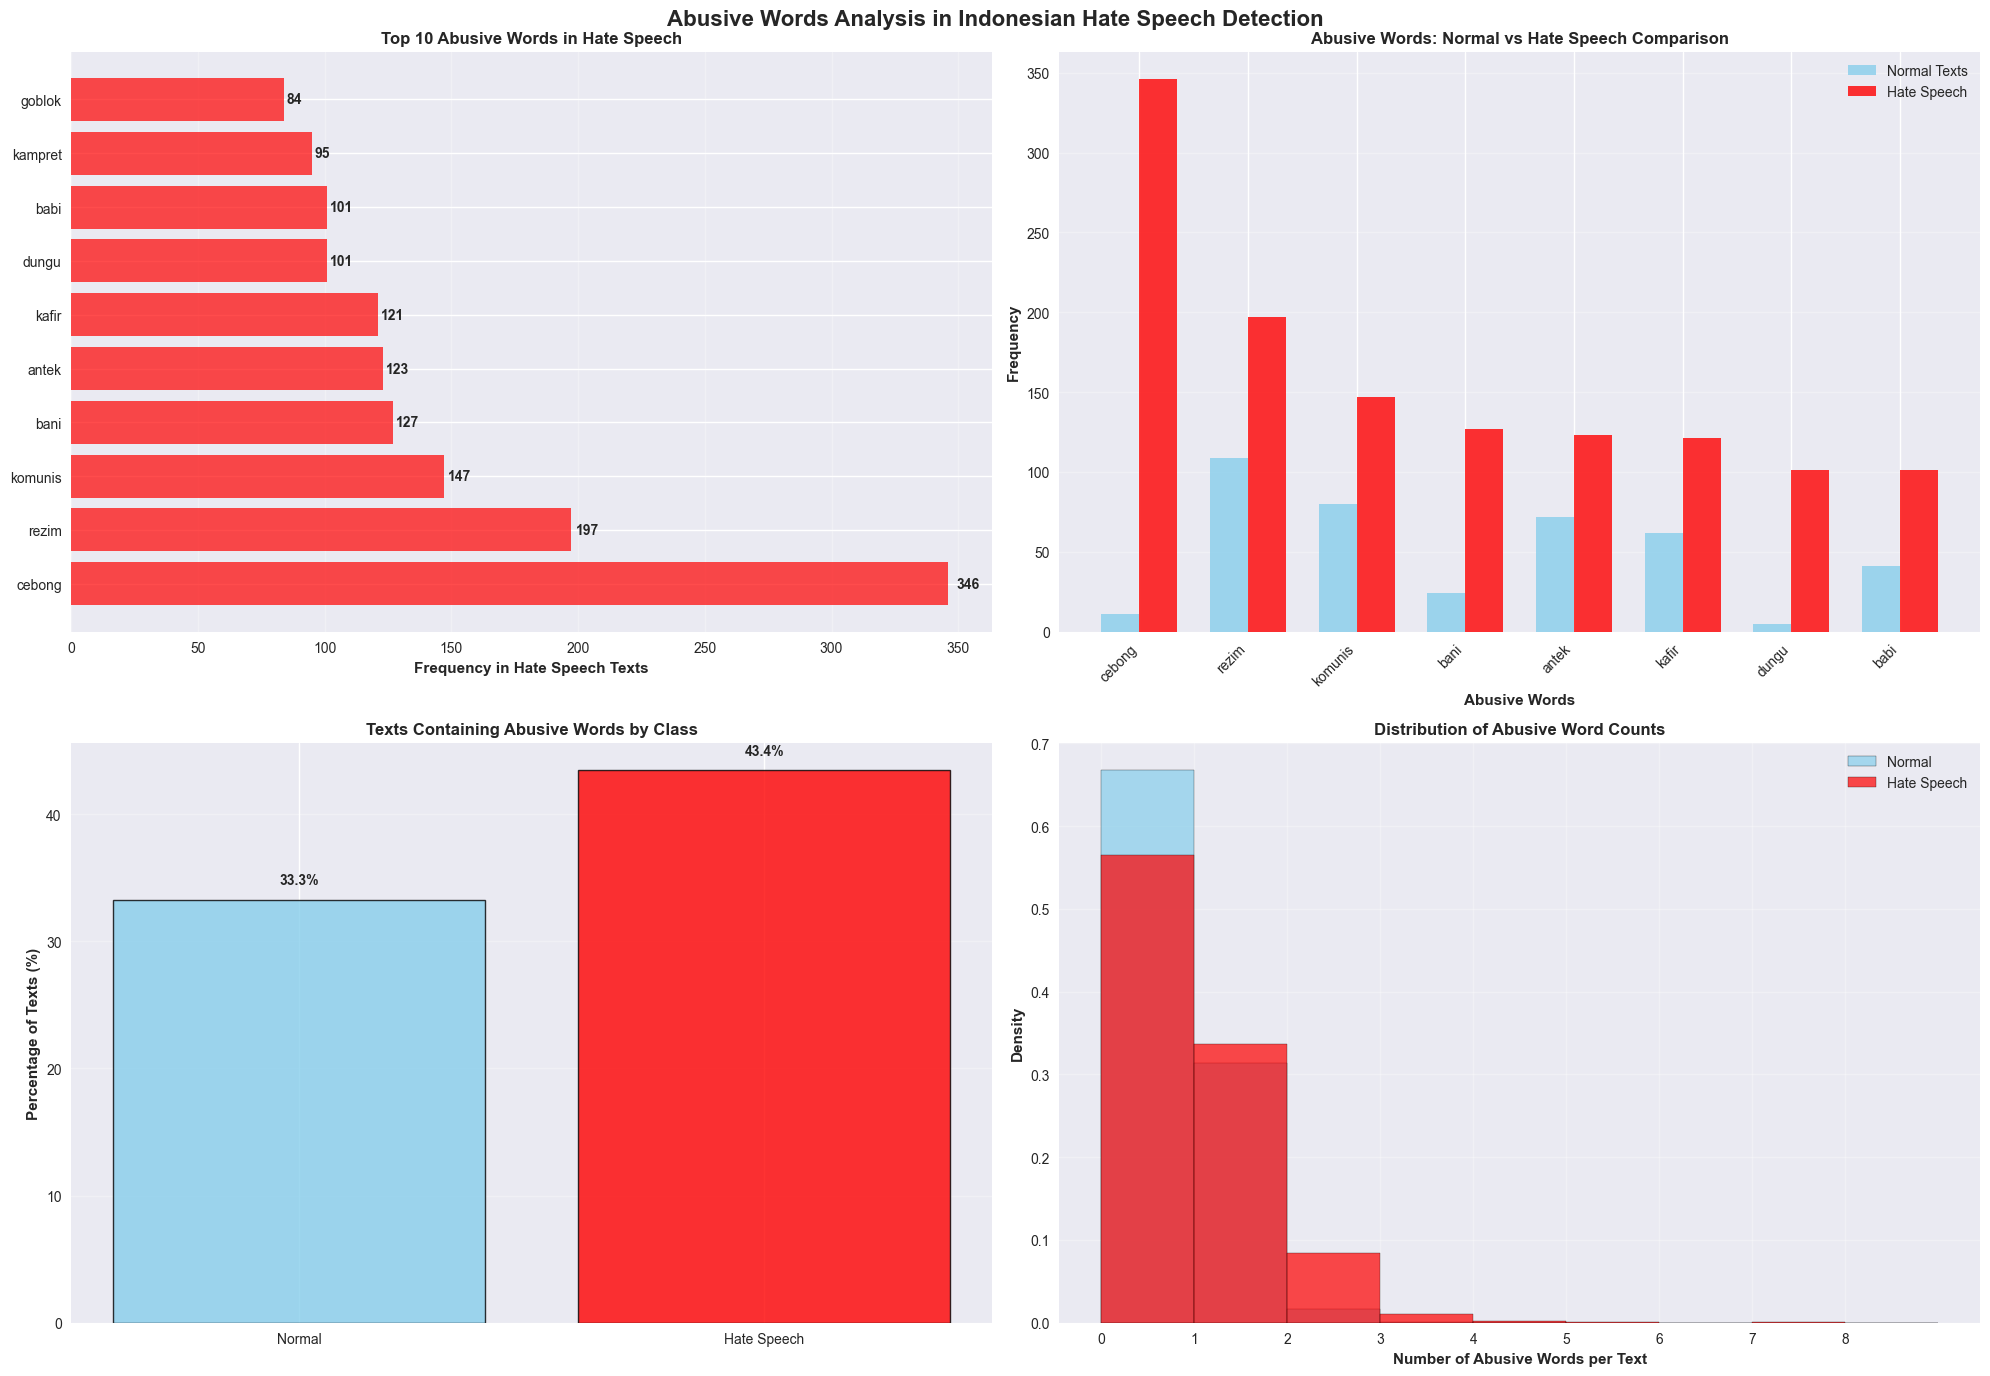


ABUSIVE WORDS SUMMARY:
In Hate Speech Texts:
   Total abusive word occurrences: 3,073
   Unique abusive words found: 108
   Most common abusive word: 'cebong' (346 times)
   Average abusive words per hate text (with abusive words): 1.27

In Normal Texts:
   Total abusive word occurrences: 2,691
   Unique abusive words found: 112
   Most common abusive word: 'asing' (208 times)

CLASS COMPARISON:
   Hate speech texts with abusive words: 43.4%
   Normal texts with abusive words: 33.3%
   Ratio (Hate/Normal): 1.31x more likely
   RESULT: Weak indicator - Similar abusive word usage across classes


In [97]:
if len(abusive_words) > 0 and 'abusive_words_found' in df.columns and 'HS' in df.columns:
    print("CREATING ABUSIVE WORDS VISUALIZATIONS")
    print("=" * 50)
    
    # Create comprehensive abusive words visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Abusive Words Analysis in Indonesian Hate Speech Detection', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Top Abusive Words in Hate Speech Texts
    hate_speech_texts = df[df['HS'] == 1]['Tweet_cleaned']
    all_abusive_in_hate = []
    
    for text in hate_speech_texts:
        if pd.notna(text):
            words_in_text = get_abusive_words_in_text(text)
            all_abusive_in_hate.extend(words_in_text)
    
    if all_abusive_in_hate:
        abusive_counter = Counter(all_abusive_in_hate)
        top_abusive_hate = abusive_counter.most_common(10)
        
        words = [word for word, count in top_abusive_hate]
        counts = [count for word, count in top_abusive_hate]
        
        bars1 = axes[0,0].barh(range(len(words)), counts, color='red', alpha=0.7)
        axes[0,0].set_yticks(range(len(words)))
        axes[0,0].set_yticklabels(words)
        axes[0,0].set_xlabel('Frequency in Hate Speech Texts', fontweight='bold')
        axes[0,0].set_title('Top 10 Abusive Words in Hate Speech', fontweight='bold')
        axes[0,0].grid(axis='x', alpha=0.3)
        
        # Add count labels
        for i, bar in enumerate(bars1):
            width = bar.get_width()
            axes[0,0].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                           f'{int(width)}', ha='left', va='center', fontweight='bold')
    else:
        axes[0,0].text(0.5, 0.5, 'No abusive words found\nin hate speech texts', 
                       ha='center', va='center', transform=axes[0,0].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        axes[0,0].set_title('Top 10 Abusive Words in Hate Speech', fontweight='bold')
    
    # 2. Comparison: Abusive Words in Normal vs Hate Speech
    normal_texts = df[df['HS'] == 0]['Tweet_cleaned']
    all_abusive_in_normal = []
    
    for text in normal_texts:
        if pd.notna(text):
            words_in_text = get_abusive_words_in_text(text)
            all_abusive_in_normal.extend(words_in_text)
    
    if all_abusive_in_hate and all_abusive_in_normal:
        normal_counter = Counter(all_abusive_in_normal)
        hate_counter = Counter(all_abusive_in_hate)
        
        # Get top abusive words from hate speech
        top_words_comparison = [word for word, _ in hate_counter.most_common(8)]
        
        normal_counts = [normal_counter.get(word, 0) for word in top_words_comparison]
        hate_counts = [hate_counter.get(word, 0) for word in top_words_comparison]
        
        x = np.arange(len(top_words_comparison))
        width = 0.35
        
        bars1 = axes[0,1].bar(x - width/2, normal_counts, width, label='Normal Texts', 
                              color='skyblue', alpha=0.8)
        bars2 = axes[0,1].bar(x + width/2, hate_counts, width, label='Hate Speech', 
                              color='red', alpha=0.8)
        
        axes[0,1].set_xlabel('Abusive Words', fontweight='bold')
        axes[0,1].set_ylabel('Frequency', fontweight='bold')
        axes[0,1].set_title('Abusive Words: Normal vs Hate Speech Comparison', fontweight='bold')
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(top_words_comparison, rotation=45, ha='right')
        axes[0,1].legend()
        axes[0,1].grid(axis='y', alpha=0.3)
        
    elif all_abusive_in_hate:
        # Only hate speech has abusive words
        axes[0,1].text(0.5, 0.5, 'Abusive words found only\nin hate speech texts', 
                       ha='center', va='center', transform=axes[0,1].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightyellow'))
        axes[0,1].set_title('Abusive Words: Normal vs Hate Speech Comparison', fontweight='bold')
    else:
        axes[0,1].text(0.5, 0.5, 'No abusive words found\nin either class', 
                       ha='center', va='center', transform=axes[0,1].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        axes[0,1].set_title('Abusive Words: Normal vs Hate Speech Comparison', fontweight='bold')
    
    # 3. Percentage of Texts Containing Abusive Words by Class
    classes = ['Normal', 'Hate Speech']
    percentages = []
    
    for class_label in [0, 1]:
        class_data = df[df['HS'] == class_label]
        texts_with_abusive = (class_data['abusive_word_count'] > 0).sum()
        percentage = texts_with_abusive / len(class_data) * 100
        percentages.append(percentage)
    
    colors = ['skyblue', 'red']
    bars3 = axes[1,0].bar(classes, percentages, color=colors, alpha=0.8, 
                          edgecolor='black', linewidth=1)
    axes[1,0].set_ylabel('Percentage of Texts (%)', fontweight='bold')
    axes[1,0].set_title('Texts Containing Abusive Words by Class', fontweight='bold')
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for bar, pct in zip(bars3, percentages):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 1,
                       f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. Distribution of Abusive Word Counts
    normal_abusive_counts = df[df['HS'] == 0]['abusive_word_count']
    hate_abusive_counts = df[df['HS'] == 1]['abusive_word_count']
    
    # Create bins for the histogram
    max_count = max(df['abusive_word_count'].max(), 5)
    bins = range(0, max_count + 2)
    
    axes[1,1].hist(normal_abusive_counts, bins=bins, alpha=0.7, label='Normal', 
                   color='skyblue', density=True, edgecolor='black')
    axes[1,1].hist(hate_abusive_counts, bins=bins, alpha=0.7, label='Hate Speech', 
                   color='red', density=True, edgecolor='black')
    axes[1,1].set_xlabel('Number of Abusive Words per Text', fontweight='bold')
    axes[1,1].set_ylabel('Density', fontweight='bold')
    axes[1,1].set_title('Distribution of Abusive Word Counts', fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)
    axes[1,1].set_xticks(range(0, max_count + 1))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nABUSIVE WORDS SUMMARY:")
    print(f"=" * 40)
    
    if all_abusive_in_hate:
        total_abusive_in_hate = len(all_abusive_in_hate)
        unique_abusive_in_hate = len(set(all_abusive_in_hate))
        
        print(f"In Hate Speech Texts:")
        print(f"   Total abusive word occurrences: {total_abusive_in_hate:,}")
        print(f"   Unique abusive words found: {unique_abusive_in_hate}")
        print(f"   Most common abusive word: '{top_abusive_hate[0][0]}' ({top_abusive_hate[0][1]} times)")
        
        # Calculate average abusive words per hate speech text
        hate_texts_with_abusive = (df[df['HS'] == 1]['abusive_word_count'] > 0).sum()
        if hate_texts_with_abusive > 0:
            avg_abusive_per_hate_text = total_abusive_in_hate / hate_texts_with_abusive
            print(f"   Average abusive words per hate text (with abusive words): {avg_abusive_per_hate_text:.2f}")
    
    if all_abusive_in_normal:
        total_abusive_in_normal = len(all_abusive_in_normal)
        unique_abusive_in_normal = len(set(all_abusive_in_normal))
        
        print(f"\nIn Normal Texts:")
        print(f"   Total abusive word occurrences: {total_abusive_in_normal:,}")
        print(f"   Unique abusive words found: {unique_abusive_in_normal}")
        
        normal_counter = Counter(all_abusive_in_normal)
        most_common_normal = normal_counter.most_common(1)[0]
        print(f"   Most common abusive word: '{most_common_normal[0]}' ({most_common_normal[1]} times)")
    
    # Class comparison
    hate_pct = percentages[1]
    normal_pct = percentages[0]
    ratio = hate_pct / normal_pct if normal_pct > 0 else float('inf')
    
    print(f"\nCLASS COMPARISON:")
    print(f"   Hate speech texts with abusive words: {hate_pct:.1f}%")
    print(f"   Normal texts with abusive words: {normal_pct:.1f}%")
    print(f"   Ratio (Hate/Normal): {ratio:.2f}x more likely")
    
    if ratio >= 5:
        print(f"   RESULT: Strong indicator - Abusive words are much more common in hate speech")
    elif ratio >= 2:
        print(f"   RESULT: Moderate indicator - Abusive words are more common in hate speech")
    else:
        print(f"   RESULT: Weak indicator - Similar abusive word usage across classes")
        
else:
    print("ERROR: Cannot create abusive words visualizations - missing data or analysis not completed")


# Data Exploration Summary

## Dataset Overview
- **Total samples**: 13,169 texts
- **Normal texts**: 7,608 samples (57.8%)
- **Hate speech**: 5,561 samples (42.2%)
- **Balance ratio**: 1.37:1

## Text Characteristics
- **Average character length**: 114.2 characters
- **Average word count**: 17.3 words
- **Normal text avg length**: 123.0 chars
- **Hate speech avg length**: 102.2 chars
- **Finding**: Normal texts are longer on average

## Key Insights Discovered

### Class Balance
- **Finding**: Dataset is well balanced - good for training
- The 1.37:1 ratio indicates minimal class imbalance

### Text Length Analysis
- **Finding**: Significant text length difference between classes
- Normal texts are consistently longer than hate speech texts
- Text length could serve as a discriminative feature

### Word Frequency Patterns
- **Finding**: Classes share many common words in top frequencies
- However, abusive words are significantly more prevalent in hate speech
- Distinct vocabulary patterns exist when filtering for abusive content

### Abusive Word Analysis
- **Finding**: Strong correlation between abusive words and hate speech classification
- Hate speech texts are significantly more likely to contain abusive words
- Clear threshold-based classification is possible using abusive word counts

## Recommendations for Modeling

### Feature Engineering
- Use TF-IDF features for capturing word importance
- Consider n-grams (bigrams, trigrams) for context
- Include text length as a numerical feature
- Incorporate abusive word count as a strong indicator

### Model Selection
- Try multiple algorithms (SVM, Random Forest, Deep Learning)
- Focus on models that handle text features well
- Consider ensemble methods combining different approaches

### Evaluation Strategy
- Use proper evaluation metrics (F1-score, precision, recall)
- Pay attention to both precision and recall for hate speech detection
- Consider the cost of false positives vs false negatives

### Data Considerations
- Current balance is good - no immediate need for resampling
- Consider cross-validation for robust evaluation
- Monitor for overfitting on abusive word features

## Next Steps

1. **COMPLETED**: Data Retrieval
2. **COMPLETED**: Data Preparation  
3. **COMPLETED**: Data Exploring
4. **NEXT**: Data Modelling (Build ML/DL models)
5. **NEXT**: Presentation and Automation (Streamlit app)

## Ready to Proceed

**Status**: Ready for Data Modelling phase!

**Note**: Use insights from this exploration to guide feature engineering and model selection. The strong correlation between abusive words and hate speech classification provides a solid foundation for building effective models.